### Обратная связь по проекту 
Шинкаренко Яна   
Telegram: [тык](https://t.me/sirena0789)

# Импорт библиотек

In [ ]:
!apt install libomp-dev
!pip install faiss-gpu
!pip install adjdatatools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import faiss
from faiss import write_index, read_index
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from adjdatatools.preprocessing import AdjustedScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.model_selection import GridSearchCV
from catboost import  cv, CatBoostRanker, CatBoostClassifier
import pickle

import warnings
warnings.simplefilter("ignore")

# Знакомство с данными

## Вспомогательные функции

In [2]:
def graph(df, color):
    features = list(df.columns)
    f_size = (10, 200)
    plt.figure(figsize=f_size)
    for i, feature in enumerate(features):
        plt.subplot(36, 2, i+1)
        plt.subplots_adjust(wspace=0.3, hspace=0.7)
        df[feature].hist(bins=100, color=color)
        plt.title(feature)
        plt.xlabel("Значение признака")
        plt.ylabel("Количество")
    return

In [3]:
def hello(df, color):
    print('Пример строк \n')
    display(df.head(5))
    print('Размер фрейма:', df.shape)
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:', df.isnull().sum().sum ())
    print('Корреляция признаков \n')
    display(df.describe())
    print('Визуализация признаков \n')
    graph(df, color)
    return

## Base dataset

In [16]:
try:
    df_base = pd.read_csv("/Users/sirena0789/Desktop/matching/data/base.csv", index_col=0)
except:
    df_base = pd.read_csv("/content/drive/MyDrive/data/base.csv", index_col=0)

Пример строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Размер фрейма: (2918139, 72)
Количество дубликатов: 0
Количество пропусков: 0
Корреляция признаков 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Визуализация признаков 



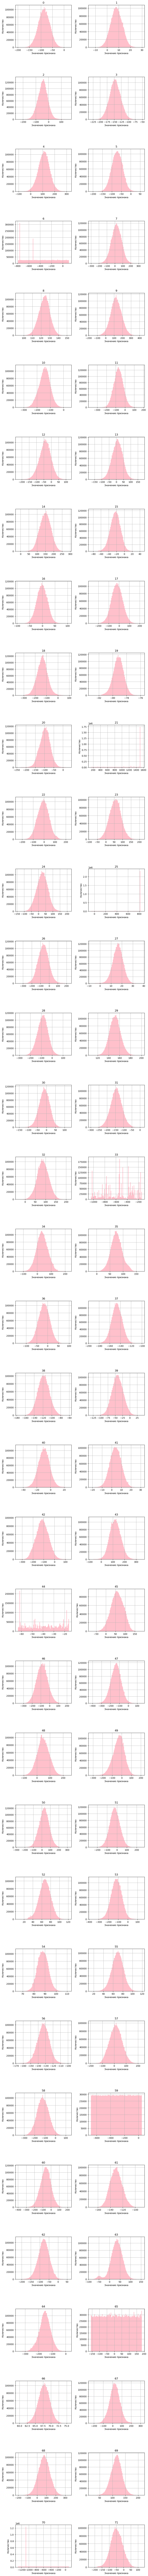

In [5]:
hello(df_base, 'pink')

## Train dataset

In [17]:
try:
    df_train = pd.read_csv("/Users/sirena0789/Desktop/matching/data/train.csv", index_col=0)
except:
    df_train = pd.read_csv("/content/drive/MyDrive/data/train.csv", index_col=0)

In [18]:
targets_train = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Пример строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


Размер фрейма: (100000, 72)
Количество дубликатов: 0
Количество пропусков: 0
Корреляция признаков 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Визуализация признаков 



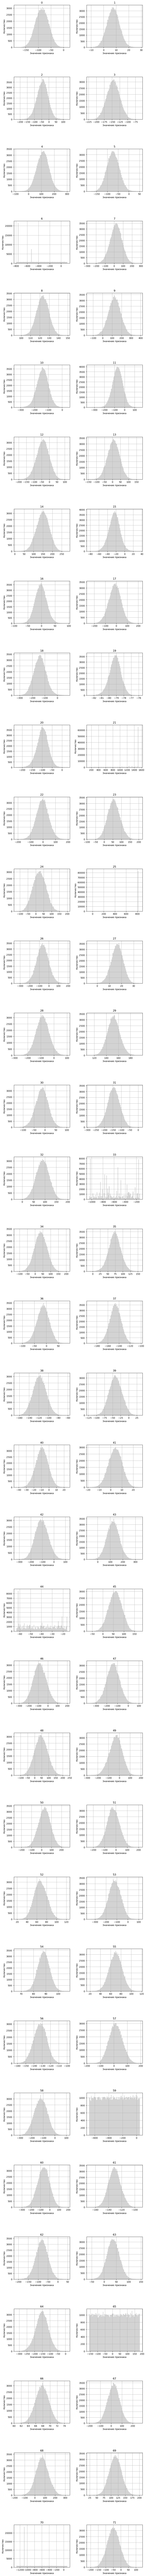

In [8]:
hello(df_train, 'lightgray')

## Validation dataset

In [19]:
try:
    df_valid = pd.read_csv("/Users/sirena0789/Desktop/matching/data/validation.csv", index_col=0)
except:
    df_valid = pd.read_csv("/content/drive/MyDrive/data/validation.csv", index_col=0)

Пример строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Размер фрейма: (100000, 72)
Количество дубликатов: 0
Количество пропусков: 0
Корреляция признаков 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


Визуализация признаков 



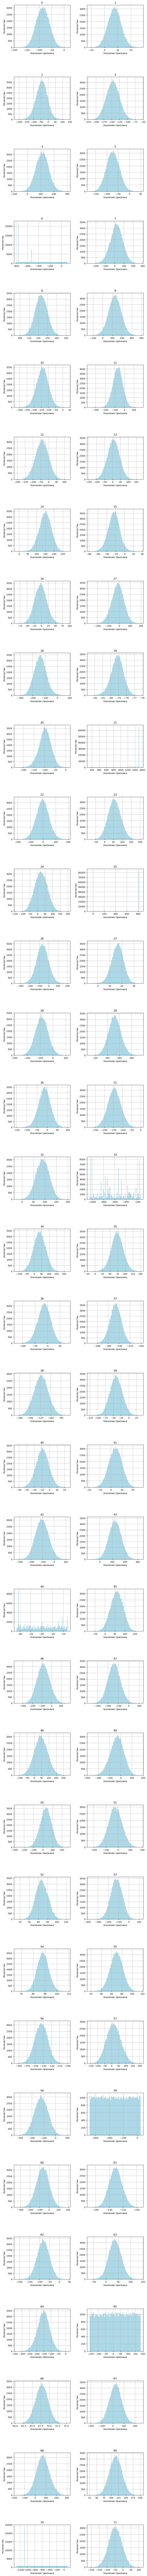

In [10]:
hello(df_valid, 'lightblue')

## Validation answer

In [2]:
try:
    df_answer = pd.read_csv("/Users/sirena0789/Desktop/matching/data/validation_answer.csv", index_col=0)
except:
    df_answer = pd.read_csv("/content/drive/MyDrive/data/validation_answer.csv", index_col=0)
df_answer

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
...,...
199995-query,967418-base
199996-query,1344948-base
199997-query,1690782-base


In [3]:
targets_valid = df_answer['Expected']

## Вывод
Всем признакам необходима нормализация, а признакам под номерами 6, 21, 25, 33, 44, 59, 65, 70 еще нужна стандартизация.

# Работа с признаками

## Вспомогательные функции

In [22]:
def st_scaler(df_base, df_train, df_valid):
    scaler = StandardScaler()
    scaler.fit(df_base)
    df_base_scaled  = scaler.transform(df_base)
    df_train_scaled = scaler.transform(df_train)
    df_valid_scaled = scaler.transform(df_valid)
    df_base_scaled = pd.DataFrame(df_base_scaled, columns = df_base.columns, index=df_base.index)
    df_train_scaled = pd.DataFrame(df_train_scaled, columns = df_train.columns, index=df_train.index)
    df_valid_scaled = pd.DataFrame(df_valid_scaled, columns = df_valid.columns, index=df_valid.index)
    return df_base_scaled, df_train_scaled, df_valid_scaled

In [14]:
def minmax_scaler(df_base, df_train):
    scaler = MinMaxScaler()
    scaler.fit(df_base)
    df_base_scaled  = scaler.transform(df_base)
    df_train_scaled = scaler.transform(df_train)
    df_base_scaled = pd.DataFrame(df_base_scaled, columns = df_base.columns)
    df_train_scaled = pd.DataFrame(df_train_scaled, columns = df_train.columns)
    return df_base_scaled, df_train_scaled

In [15]:
def adj_scaler(df_base, df_train):
    scaler = AdjustedScaler()
    scaler.fit(df_base)
    df_base  = scaler.transform(df_base)
    df_train = scaler.transform(df_train)
    return df_base, df_train

## Основная часть

Создадим три группы выборок для трех разных методов масштабирования данных.

In [18]:
df_base_minmax = df_base
df_base_adj = df_base

df_train_minmax = df_train
df_train_adj = df_train

### StandardScaler

In [23]:
%%time

df_base, df_train, df_valid = st_scaler(df_base, df_train, df_valid)

CPU times: user 1.37 s, sys: 1.82 s, total: 3.19 s
Wall time: 3.7 s


### MinMaxScaler

In [20]:
%%time

df_base_minmax, df_train_minmax = minmax_scaler(df_base_minmax, df_train_minmax)

CPU times: user 750 ms, sys: 1.54 s, total: 2.29 s
Wall time: 3.44 s


### AdjustedScaler

In [21]:
%%time

df_base_adj, df_train_adj = adj_scaler(df_base_adj, df_train_adj)

CPU times: user 1min 39s, sys: 1min 7s, total: 2min 47s
Wall time: 3min 3s


Далее сгенерируем словарь с индексами из base. Он понадобится далее.

In [24]:
base_index = {i: j for i, j in enumerate(df_base.index.to_list())}

## Вывод
По времени работы методы StandardScaler и MinMaxScaler показали себя одинаково хорошо, а вот AdjustedScaler работает в 52 раза дольше конкурентов. Посмотрим как они покажут себя на метрике.

# Метод ближайших соседей

## StandardScaler

### 10 соседей

In [26]:
%%time


dimensions = df_base.shape[1]
idx_l2 = faiss.IndexFlatL2(dimensions)

idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))


top_count = 10

vectors_train_10, idx_train_10 = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), top_count)

vectors_valid_10, idx_valid_10 = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), top_count)

acc_train = 0
for target, candidates in zip(targets_train.values.tolist(), idx_train_10.tolist()):
    acc_train += int(target in [base_index[number] for number in candidates])
    
acc_valid = 0
for target, candidates in zip(targets_valid.values.tolist(), idx_valid_10.tolist()):
    acc_valid += int(target in [base_index[number] for number in candidates])

print('accuracy train : {}%'.format(acc_train / len(idx_train_10) * 100))
print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_10) * 100))

accuracy train : 69.789%
accuracy valid : 69.616%
CPU times: user 1h 26min 22s, sys: 5min, total: 1h 31min 23s
Wall time: 12min 1s


### 100 соседей

In [69]:
%%time


dimensions = df_base.shape[1]
idx_l2 = faiss.IndexFlatL2(dimensions)

idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))


top_count = 100

vectors_train, idx_train = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), top_count)

vectors_valid, idx_valid = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), top_count)

acc_train = 0
for target, candidates in zip(targets_train.values.tolist(), idx_train.tolist()):
    acc_train += int(target in [base_index[number] for number in candidates])
    
acc_valid = 0
for target, candidates in zip(targets_valid.values.tolist(), idx_valid.tolist()):
    acc_valid += int(target in [base_index[number] for number in candidates])

print('accuracy train : {}%'.format(acc_train / len(idx_train) * 100))
print('accuracy valid : {}%'.format(acc_valid / len(idx_valid) * 100))

accuracy train : 79.178%
accuracy valid : 79.125%
CPU times: user 1h 36min 2s, sys: 5min 15s, total: 1h 41min 18s
Wall time: 13min 3s


## MinMaxScaler

In [27]:
%%time


dimensions = df_base_minmax.shape[1]  
idx_l2 = faiss.IndexFlatL2(dimensions)

idx_l2.train(np.ascontiguousarray(df_base_minmax.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_minmax.values).astype('float32'))


top_count = 10
vectors_minmax, idx_minmax = idx_l2.search(np.ascontiguousarray(df_train_minmax.values).astype('float32'), top_count)

acc_minmax = 0
for target, candidates in zip(targets.values.tolist(), idx_minmax.tolist()):
    acc_minmax += int(target in [base_index[number] for number in candidates])

print('accuracy MinMax: {}%'.format(acc_minmax / len(idx_minmax) * 100))

accuracy MinMax: 38.263000000000005%
CPU times: user 42min 50s, sys: 2min 33s, total: 45min 23s
Wall time: 6min 12s


## AdjustedScaler

In [25]:
%%time


dimensions = df_base_adj.shape[1] 
idx_l2 = faiss.IndexFlatL2(dimensions)

idx_l2.train(np.ascontiguousarray(df_base_adj.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_adj.values).astype('float32'))


top_count = 10
vectors_adj, idx_adj = idx_l2.search(np.ascontiguousarray(df_train_adj.values).astype('float32'), top_count)

acc_adj = 0
for target, candidates in zip(targets.values.tolist(), idx_adj.tolist()):
    acc_adj += int(target in [base_index[number] for number in candidates])

print('accuracy AdjustedScaler: {}%'.format(acc_adj / len(idx_adj) * 100))

accuracy adj: 58.330000000000005%
CPU times: user 43min 25s, sys: 2min 30s, total: 45min 55s
Wall time: 6min 14s


### Загрузка списка кандидатов в файл

#### 10 кандидатов

In [28]:
try:
    filename = '/Users/sirena0789/Desktop/matching/data/idx_train_10.txt'
    pickle.dump(idx_train_10, open(filename, 'wb'))
    filename = '/Users/sirena0789/Desktop/matching/data/idx_valid_10.txt'
    pickle.dump(idx_valid_10, open(filename, 'wb'))
except:
    filename = '/content/drive/MyDrive/data/idx_train_10.txt'
    pickle.dump(idx_train_10, open(filename, 'wb'))
    filename = '/content/drive/MyDrive/data/idx_valid_10.txt'
    pickle.dump(idx_valid_10, open(filename, 'wb'))

#### 100 кандидатов

In [ ]:
try:
    filename = '/Users/sirena0789/Desktop/matching/data/idx_train.txt'
    pickle.dump(idx_train, open(filename, 'wb'))
    filename = '/Users/sirena0789/Desktop/matching/data/idx_valid.txt'
    pickle.dump(idx_valid, open(filename, 'wb'))
except:
    filename = '/content/drive/MyDrive/data/idx_train.txt'
    pickle.dump(idx_train, open(filename, 'wb'))
    filename = '/content/drive/MyDrive/data/idx_valid.txt'
    pickle.dump(idx_valid, open(filename, 'wb'))

### Загрузка списка кандидатов из файла (опционально)

#### 10 кандидатов

In [ ]:
try:
    filename = '/Users/sirena0789/Desktop/matching/data/idx_train_10.txt'
    idx_train = pickle.load(open(filename, 'rb'))
    filename = '/Users/sirena0789/Desktop/matching/data/idx_valid_10.txt'
    idx_valid = pickle.load(open(filename, 'rb'))
except: 
    filename = '/content/drive/MyDrive/data/idx_train_10.txt'
    idx_train = pickle.load(open(filename, 'rb'))
    filename = '/content/drive/MyDrive/data/idx_valid_10.txt'
    idx_valid = pickle.load(open(filename, 'rb'))

#### 100 кандидатов

In [10]:
try:
    filename = '/Users/sirena0789/Desktop/matching/data/idx_train.txt'
    idx_train = pickle.load(open(filename, 'rb'))
    filename = '/Users/sirena0789/Desktop/matching/data/idx_valid.txt'
    idx_valid = pickle.load(open(filename, 'rb'))
except: 
    filename = '/content/drive/MyDrive/data/idx_train.txt'
    idx_train = pickle.load(open(filename, 'rb'))
    filename = '/content/drive/MyDrive/data/idx_valid.txt'
    idx_valid = pickle.load(open(filename, 'rb'))

## Вывод
Лучше остальных по метрике показал себя StandardScaler. Им и воспользуемся в дальнейшем.

# Создание датафрейма для обучения

## Вспомогательные функции

### Функции для "подтягивания" индексов

In [29]:
def index_get(i):
    return base_index[i['inx']]

In [30]:
def index_get_tar_tr(i):
    return targets_train[i['query_inx']]

In [31]:
def index_get_tar_val(i):
    return targets_valid[i['query_inx']]

### Функция для создания итогового фрейма

In [35]:
def frame_train(df_train, idx_train):
    dictionary = []
    idx = df_train.index.tolist()
    index_train = idx_train.tolist()

    for i in range(len(idx)):
        for j in range(len(index_train[i])):
            dictionary.append([idx[i], index_train[i][j]])

    dictionary = pd.DataFrame(dictionary)
    dictionary.columns = ['query_inx', 'inx']
    dictionary['base_inx'] = dictionary.apply(index_get, axis=1)
    final_df_train = dictionary.merge(df_base, how='inner', left_on='base_inx', right_index=True)
    final_df_train = final_df_train.merge(df_train, how='inner', left_on='query_inx', right_index=True)
    final_df_train['target_inx'] = final_df_train.apply(index_get_tar_tr, axis=1)
    final_df_train['target'] = final_df_train['target_inx'] == final_df_train['base_inx']
    final_df_train['target'] = final_df_train['target'].astype('int')
    return final_df_train

In [36]:
def frame_valid(df_train, idx_train):
    dictionary = []
    idx = df_train.index.tolist()
    index_train = idx_train.tolist()

    for i in range(len(idx)):
        for j in range(len(index_train[i])):
            dictionary.append([idx[i], index_train[i][j]])

    dictionary = pd.DataFrame(dictionary)
    dictionary.columns = ['query_inx', 'inx']
    dictionary['base_inx'] = dictionary.apply(index_get, axis=1)
    final_df_train = dictionary.merge(df_base, how='inner', left_on='base_inx', right_index=True)
    final_df_train = final_df_train.merge(df_train, how='inner', left_on='query_inx', right_index=True)
    final_df_train['target_inx'] = final_df_train.apply(index_get_tar_val, axis=1)
    final_df_train['target'] = final_df_train['target_inx'] == final_df_train['base_inx']
    final_df_train['target'] = final_df_train['target'].astype('int')
    return final_df_train

## Основная часть

### 10 кандидатов

In [38]:
final_df_train_10 = frame_train(df_train, idx_train_10)
final_df_valid_10 = frame_valid(df_valid, idx_valid_10)

####  Сохранение фреймов в файл

In [39]:
final_df_train_10.to_csv('/Users/sirena0789/Desktop/matching/data/final_df_train_10.csv')
final_df_valid_10.to_csv('/Users/sirena0789/Desktop/matching/data/final_df_valid_10.csv')

#### Чтение фреймов из файла (опционально)

In [ ]:
final_df_train_10 = pd.read_csv('/Users/sirena0789/Desktop/matching/data/final_df_train_10.csv', index_col=0)
final_df_valid_10 = pd.read_csv('/Users/sirena0789/Desktop/matching/data/final_df_valid_10.csv', index_col=0)

### 100 кандидатов

### Краткая версия (при наличии большого обьема оперативной памяти)

In [ ]:
final_df_train = frame(df_train, idx_train)
final_df_valid = frame(df_valid, idx_valid)

### Поэтапная версия

### Фрейм с тренировочной выборкой

In [28]:
dictionary = []
idx = df_train.index.tolist()
index_train = idx_train.tolist()

for i in range(len(idx)):
    for j in range(len(index_train[i])):
        dictionary.append([idx[i], index_train[i][j]])

dictionary = pd.DataFrame(dictionary)
dictionary.columns = ['query_inx', 'inx']
dictionary['base_inx'] = dictionary.apply(index_get, axis=1)
final_df_train = dictionary.merge(df_base, how='inner', left_on='base_inx', right_index=True)
final_df_train = final_df_train.merge(df_train, how='inner', left_on='query_inx', right_index=True)

In [21]:
final_df_train['target_inx'][:2500000] = final_df_train[:2500000].apply(index_get_tar_tr, axis=1)

In [ ]:
final_df_train['target_inx'][2500000:5000000] = final_df_train[2500000:5000000].apply(index_get_tar_tr, axis=1)

In [ ]:
final_df_train['target_inx'][5000000:7500000] = final_df_train[5000000:7500000].apply(index_get_tar_tr, axis=1)

In [40]:
final_df_train['target_inx'][7500000:10000000] = final_df_train[7500000:10000000].apply(index_get_tar_tr, axis=1)

In [25]:
final_df_train['target'] = final_df_train['target_inx'] == final_df_train['base_inx']
final_df_train['target'] = final_df_train['target'].astype('int')

####  Сохранение фрейма в файл

In [ ]:
final_df_train.to_csv('/Users/sirena0789/Desktop/matching/data/final_df_train.csv')

#### Чтение фрейма из файла (опционально)

In [52]:
final_df_train = pd.read_csv('/Users/sirena0789/Desktop/matching/data/final_df_train.csv', index_col=0)

### Фрейм с тестовой выборкой

In [14]:
dictionary = []
idx = df_valid.index.tolist()
index_valid = idx_valid.tolist()

for i in range(len(idx)):
    for j in range(len(index_valid[i])):
        dictionary.append([idx[i], index_valid[i][j]])

dictionary = pd.DataFrame(dictionary)
dictionary.columns = ['query_inx', 'inx']

In [16]:
dictionary['base_inx'] = dictionary.apply(index_get, axis=1)

In [17]:
final_df_valid = dictionary.merge(df_base, how='inner', left_on='base_inx', right_index=True)

In [18]:
final_df_valid = final_df_valid.merge(df_valid, how='inner', left_on='query_inx', right_index=True)

In [21]:
final_df_valid['target_inx'] = final_df_valid[:2500000].apply(index_get_tar_val, axis=1)

In [23]:
final_df_valid['target_inx'][2500000:5000000] = final_df_valid[2500000:5000000].apply(index_get_tar_val, axis=1)

In [24]:
final_df_valid['target_inx'][5000000:7500000] = final_df_valid[5000000:7500000].apply(index_get_tar_val, axis=1)

In [25]:
final_df_valid['target_inx'][7500000:10000000] = final_df_valid[7500000:10000000].apply(index_get_tar_val, axis=1)

In [26]:
final_df_valid['target'] = final_df_valid['target_inx'] == final_df_valid['base_inx']

In [27]:
final_df_valid['target'] = final_df_valid['target'].astype('int')

#### Сохранение фрейма в файл

In [28]:
final_df_valid.to_csv('/Users/sirena0789/Desktop/matching/data/final_df_valid.csv')

#### Чтение фрейма из файла (опционально)

In [4]:
final_df_valid = pd.read_csv('/Users/sirena0789/Desktop/matching/data/final_df_valid.csv', index_col=0)

### Подготовка выборок для обучения и тестирования

#### 10 кандидатов

In [42]:
target_train_10 = final_df_train_10['target']
feature_train_10 = final_df_train_10.drop(['query_inx', 'inx', 'base_inx', 'target_inx', 'target'], axis=1)

target_valid_10 = final_df_valid_10['target']
feature_valid_10 = final_df_valid_10.drop(['query_inx', 'inx', 'base_inx', 'target_inx', 'target'], axis=1)

#### 100 кандидатов

#### Формирование среза датасета для обучения

In [ ]:
final_df_train_slice = final_df_train[:1000000]

In [57]:
target_train = final_df_train_slice['target']
feature_train = final_df_train_slice.drop(['query_inx', 'inx', 'base_inx', 'target_inx', 'target'], axis=1)

In [5]:
target_valid = final_df_valid['target']

In [6]:
feature_valid = final_df_valid.drop(['query_inx', 'inx', 'base_inx', 'target_inx', 'target'], axis=1)

### Расчет весов

In [43]:
weight_10 = target_train_10[target_train_10 == 0].count() / target_train_10[target_train_10 == 1].count()

In [ ]:
weight = target_train[target_train == 0].count() / target_train[target_train == 1].count()

## Обучение модели

### Формирование, подбор гиперпараметров и обучение модели CatBoostClassifier

#### 10 кандидатов

In [45]:
%%time

model = CatBoostClassifier(random_state=1234, verbose=False, scale_pos_weight = weight_10) 

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[3000]}]

cbr_10 = GridSearchCV(estimator = model, param_grid = params, cv = 2, n_jobs = -1 ,scoring='accuracy')

cbr_10.fit(feature_train_10, target_train_10)

estimator = cbr_10.best_estimator_
filename = "/Users/sirena0789/Desktop/matching/data/model_CatBoost_10.cbm"
pickle.dump(estimator, open(filename, 'wb'))

CPU times: user 39min 14s, sys: 25.4 s, total: 39min 40s
Wall time: 17min 7s


#### 100 кандидатов

In [59]:
%%time

model = CatBoostClassifier(random_state=1234, verbose=False, scale_pos_weight = weight) 

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[3000]}]

cbr = GridSearchCV(estimator = model, param_grid = params, cv = 2, n_jobs = -1 ,scoring='accuracy')

cbr.fit(feature_train, target_train)

estimator = cbr.best_estimator_
filename = "/Users/sirena0789/Desktop/matching/data/model_CatBoost.cbm"
pickle.dump(estimator, open(filename, 'wb'))

CPU times: user 40min 7s, sys: 25 s, total: 40min 32s
Wall time: 16min 54s


### Загрузка обученной модели  из файла (опционально)

#### 10 кандидатов

In [47]:
filename = "/Users/sirena0789/Desktop/matching/data/model_CatBoost_10.cbm"
cbr_10 = pickle.load(open(filename, 'rb'))

#### 100 кандидатов

In [8]:
filename = "/Users/sirena0789/Desktop/matching/data/model_CatBoost.cbm"
cbr = pickle.load(open(filename, 'rb'))

### Расчет accuracy

#### 10 кандидатов

In [48]:
%%time

pred_10 = cbr_10.predict(feature_valid_10)
accuracy_10 = accuracy_score(target_valid_10, pred_10)
print('accuracy score:', accuracy_10)

accuracy score: 0.929851
CPU times: user 3.92 s, sys: 738 ms, total: 4.65 s
Wall time: 1.4 s


#### 100 кандидатов

In [9]:
%%time

pred = cbr.predict(feature_valid)
accuracy = accuracy_score(target_valid, pred)
print('accuracy score:', accuracy)

accuracy score: 0.8923139
CPU times: user 34.8 s, sys: 8.49 s, total: 43.3 s
Wall time: 20.5 s


### Получение предсказаний для расчета accuracy@5 и сохранение в файл

In [ ]:
%%time

probs_10 = cbr_10.predict_proba(feature_valid_10)[:, 1]

filename = '/Users/sirena0789/Desktop/matching/data/proba_10.txt'
pickle.dump(probs_10, open(filename, 'wb'))

In [11]:
%%time

probs = cbr.predict_proba(feature_valid)[:, 1]

filename = '/Users/sirena0789/Desktop/matching/data/proba.txt'
pickle.dump(probs, open(filename, 'wb'))

CPU times: user 32.8 s, sys: 8.78 s, total: 41.6 s
Wall time: 20.8 s


### Загрузка предсказаний из файла (опционально)

In [11]:
filename = '/Users/sirena0789/Desktop/matching/data/proba_10.txt'
probs_10 = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/Users/sirena0789/Desktop/matching/data/proba.txt'
probs = pickle.load(open(filename, 'rb'))

### Добавление предсказаний во фрейм и подготовка промежуточной таблицы для рассчета метрики

In [50]:
final_df_valid_10["predicted_prob"] = probs_10
sorted_candidates_10 = final_df_valid_10.groupby("query_inx").apply(lambda x: x.nlargest(5, "predicted_prob")).reset_index(drop=True)

In [ ]:
final_df_valid["predicted_prob"] = probs
sorted_candidates = final_df_valid.groupby("query_inx").apply(lambda x: x.nlargest(5, "predicted_prob")).reset_index(drop=True)

### Расчет accuracy@5

In [51]:
correct = 0
for row, i in tqdm(df_answer.iterrows()):
    top_5 = sorted_candidates_10[sorted_candidates_10["query_inx"] == row]["base_inx"].tolist()
    if i["Expected"] in top_5:
        correct += 1

accuracy_at_5 = correct / len(df_answer)
print('accuracy@5 score of 10 candidates:', accuracy_at_5)

0it [00:00, ?it/s]

accuracy@5 score of 10 candidates: 0.691


In [35]:
correct = 0
for row, i in tqdm(df_answer.iterrows()):
    top_5 = sorted_candidates[sorted_candidates["query_inx"] == row]["base_inx"].tolist()
    if i["Expected"] in top_5:
        correct += 1

accuracy_at_5 = correct / len(df_answer)
print('accuracy@5 score of 100 candidates:', accuracy_at_5)

0it [00:00, ?it/s]

0.691

### Вывод


## Анализ важности признаков

In [ ]:
im_df = pd.DataFrame(cbr_10.best_estimator_.feature_importances_,
                     index = feature_train_10.columns, columns=['import'])
im_df = im_df.sort_values(by='import', ascending=False)
im_df.plot(kind='bar', figsize=(10, 5), title='Важность признаков', color='pink', legend=False)
plt.show()

In [47]:
ignored_features = np.array(feature_train.columns)[sorted_idx][:75]